# CS4035 - Cyber Data Analytics
## Lab 3 

# --- NOTES ---

- Discretize each "netflow" (which is just a single packet/row)
- For each feature, create "bins" for the values (nunique? LabelEncoder?) 
- Concatenate all of these bins into a single feature, such that the dataset only has one feature (confirm?)
- Use k-means to create clusters, and then "utilize the interaction between the features to come up with the features" (optional)


- [Student] "so each row has 1 feature after the concatenation. Since we need a 3-gram, doesn't this essentialy mean that we take row 1, row 2 and row 3 as the first 3-gram? Is then the second 3-gram, row 2, row 3, row 4?"
- [Daniel Vos] "Yes, essentially. You summarize each row with one number/symbol and take 3-grams of these numbers/symbols"

---
Week 7:

- Using a .random() value is equivalent to using a hash function for determining an index, if hashing is too slow. 
- MurmurHash is a non-cryptographic hash function library that is faster than a cryptographic hash library.


### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name: Andrew Gold
### ID: 4995902

## Student 2
### Name: Srinath Jayaraman
### ID: 5049903

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

- Be sure to install the following: 
    - the python wrapper for murmurhash3: `pip install mmh3`

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import mmh3
import re
import time


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

In [2]:
df_10 = pd.read_csv("C:/Users/srina/Downloads/dataset_lab3/dataset_10/capture20110818.binetflow")

# Drop the following columns because...
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)
df_10.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label
0,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill
1,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
2,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
3,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek
4,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek


In [3]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122199 entries, 0 to 122198
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Dur       122199 non-null  float64
 1   Proto     122199 non-null  object 
 2   SrcAddr   122199 non-null  object 
 3   Sport     122172 non-null  object 
 4   Dir       122199 non-null  object 
 5   DstAddr   122199 non-null  object 
 6   Dport     21003 non-null   object 
 7   State     120972 non-null  object 
 8   TotPkts   122199 non-null  int64  
 9   TotBytes  122199 non-null  int64  
 10  SrcBytes  122199 non-null  int64  
 11  Label     122199 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 11.2+ MB


## 1. Familiarization and discretization task – 1 A4

In [4]:
# First let's see what kind of null values we've got
df_10.isnull().sum()

Dur              0
Proto            0
SrcAddr          0
Sport           27
Dir              0
DstAddr          0
Dport       101196
State         1227
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64

In [5]:
# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER

In [6]:
# Remove hexadecimal values from the dataset
df_10.Dport = df_10.Dport.astype('str')
df_10.Sport = df_10.Sport.astype('str')

df_10.Dport = df_10.Dport.apply(lambda x: int(str(x), 0))
df_10.Sport = df_10.Sport.apply(lambda x: int(str(x), 0))

df_10.Dport

0           443
1            80
2            80
3            53
4            53
          ...  
122194    33822
122195    33822
122196       53
122197       53
122198       80
Name: Dport, Length: 122199, dtype: int64

In [7]:
# Let's create a meta-label attribute for each protocol type for botnet activity
df_10['MetaLabel'] = pd.Series()
# df_10_inf.Metalabel.loc[np.where(df_10_inf.Label.str.contains('Normal'))] = 'Normal'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('TCP'))] = 'Botnet-TCP'

df_10


<ipython-input-7-bce7a68da95d>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['MetaLabel'] = pd.Series()


,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel
0,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill,NaN
1,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill,NaN
2,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill,NaN
3,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek,NaN
4,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122194,0.000743,icmp,147.32.84.164,8,<->,147.32.96.69,33822,ECO,2,196,98,flow=From-Normal-V51-Grill,NaN
122195,0.000913,icmp,147.32.84.164,8,<->,147.32.96.69,33822,ECO,2,196,98,flow=From-Normal-V51-Grill,NaN
122196,0.000414,udp,147.32.84.170,37138,<->,147.32.80.9,53,CON,2,244,81,flow=From-Normal-V51-Stribrek,NaN
122197,0.000322,udp,147.32.84.170,39771,<->,147.32.80.9,53,CON,2,280,81,flow=From-Normal-V51-Stribrek,NaN


In [8]:
# Identify the infected hosts:
inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].SrcAddr.unique()
inf

array(['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193',
       '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207',
       '147.32.84.208', '147.32.84.209'], dtype=object)

In [9]:
# see the activity level of each infected host
df_10.SrcAddr.loc[np.where(df_10.Label.str.contains('Botnet'))].value_counts()

147.32.84.205    11874
147.32.84.206    11287
147.32.84.204    11159
147.32.84.208    11118
147.32.84.207    10581
147.32.84.191    10454
147.32.84.192    10397
147.32.84.193    10009
147.32.84.209     9894
147.32.84.165     9579
Name: SrcAddr, dtype: int64

<BarContainer object of 10 artists>

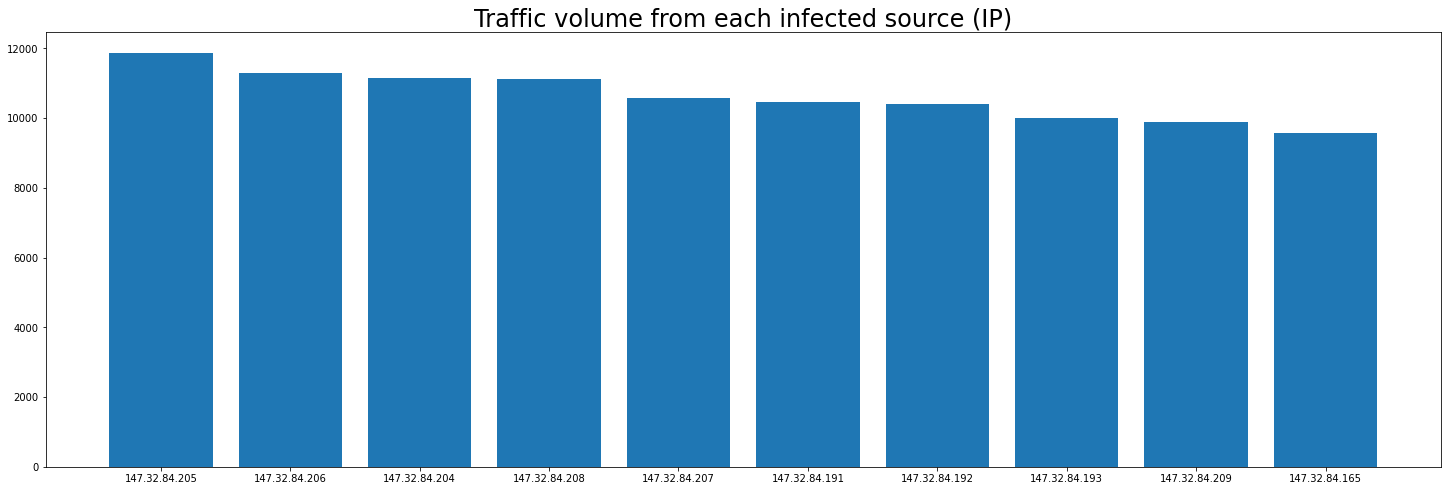

In [10]:
# visualization of amount of traffic from each infected source
fig = plt.figure(figsize=(25,8))
plt.title('Traffic volume from each infected source (IP)', size=24)
plt.bar(df_10.loc[df_10.SrcAddr.isin(inf)].SrcAddr.value_counts().index,
        df_10.loc[df_10.SrcAddr.isin(inf)].SrcAddr.value_counts())

In [11]:
# pick one of the hosts (we'll choose the one with the most traffic)
df_10_inf_1 = df_10.loc[df_10.SrcAddr == '147.32.84.205'].reset_index(inplace=False)
df_10_inf_1

,index,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel
0,1473,0.000263,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,203,64,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
1,1474,0.000401,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,590,87,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
2,1475,0.075763,tcp,147.32.84.205,1027,->,74.125.232.199,80,SRPA_SPA,7,882,629,flow=From-Botnet-V51-6-TCP-HTTP-Google-Net-Est...,Botnet-TCP
3,1478,0.000450,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,479,76,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
4,1479,3.017135,udp,147.32.84.205,123,->,65.55.56.40,123,INT,2,180,180,flow=From-Botnet-V51-6-UDP-Attempt,Botnet-UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11869,121650,367.653198,tcp,147.32.84.205,1026,->,216.155.130.130,6667,SPA_SPA,55,14273,1662,flow=From-Botnet-V51-6-TCP-CC106-IRC-Not-Encry...,Botnet-TCP
11870,121654,0.000455,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,590,87,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
11871,121655,0.044163,tcp,147.32.84.205,1028,->,74.125.232.202,80,SRPA_SPA,7,882,629,flow=From-Botnet-V51-6-TCP-HTTP-Google-Net-Est...,Botnet-TCP
11872,121656,0.000412,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,479,76,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP


In [12]:
df_10_inf_1.Proto.value_counts()

icmp    11836
udp        30
tcp         8
Name: Proto, dtype: int64

<BarContainer object of 3 artists>

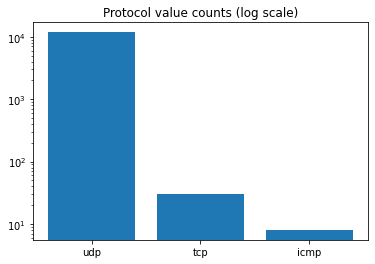

In [13]:
# Let's see what the frequency of each type of packet is
plt.yscale('log')
plt.title('Protocol value counts (log scale)')
plt.bar(df_10_inf_1.Proto.unique(), df_10_inf_1.Proto.value_counts())

<BarContainer object of 2 artists>

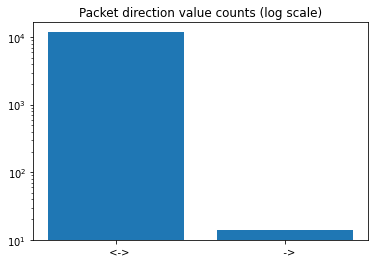

In [14]:
# frequency of each type of directional traffic
plt.yscale('log')
plt.title('Packet direction value counts (log scale)')
plt.bar(df_10_inf_1.Dir.unique(), df_10_inf_1.Dir.value_counts())

In [15]:
df_10_enc = df_10_inf_1.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)


In [16]:
print(df_10_enc.MetaLabel.value_counts().to_string())

Botnet-ICMP    11836
Botnet-UDP        30
Botnet-TCP         8


In [17]:
df_10_enc['EncLabel'] = pd.Series()
# df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('Normal'))] = 0
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3

df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')
df_10_enc.EncLabel

<ipython-input-17-36a56fe13de3>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()


0        2
1        2
2        3
3        2
4        2
        ..
11869    3
11870    2
11871    3
11872    2
11873    2
Name: EncLabel, Length: 11874, dtype: int8

In [18]:
# might not want to blindly encode these:
df_10_enc.Label = LabelEncoder().fit_transform(df_10_enc.Label)
print(df_10_enc.MetaLabel.value_counts())

Botnet-ICMP    11836
Botnet-UDP        30
Botnet-TCP         8
Name: MetaLabel, dtype: int64


In [19]:
df_10_enc.head(10)

,index,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel,EncLabel
0,1473,0.000263,2,0,53,1,0,190,1,1,2,1,5,Botnet-UDP,2
1,1474,0.000401,2,0,53,1,0,190,1,1,6,4,5,Botnet-UDP,2
2,1475,0.075763,1,0,57,0,5,221,30,4,7,7,2,Botnet-TCP,3
3,1478,0.000450,2,0,53,1,0,190,1,1,4,2,5,Botnet-UDP,2
4,1479,3.017135,2,0,426,0,4,28,7,1,1,5,4,Botnet-UDP,2
5,1974,0.000465,2,0,53,1,0,190,1,1,5,2,5,Botnet-UDP,2
6,1975,3570.946045,1,0,68,0,9,205,28,51,33,12,1,Botnet-TCP,3
7,2492,0.000227,2,0,53,1,0,190,1,1,2,1,5,Botnet-UDP,2
8,2497,0.000384,2,0,53,1,0,190,1,1,3,3,5,Botnet-UDP,2
9,2498,60.004951,1,0,72,0,2,221,30,5,9,6,3,Botnet-TCP,3


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

Text(0.5, 1.0, 'Correlation heat map')

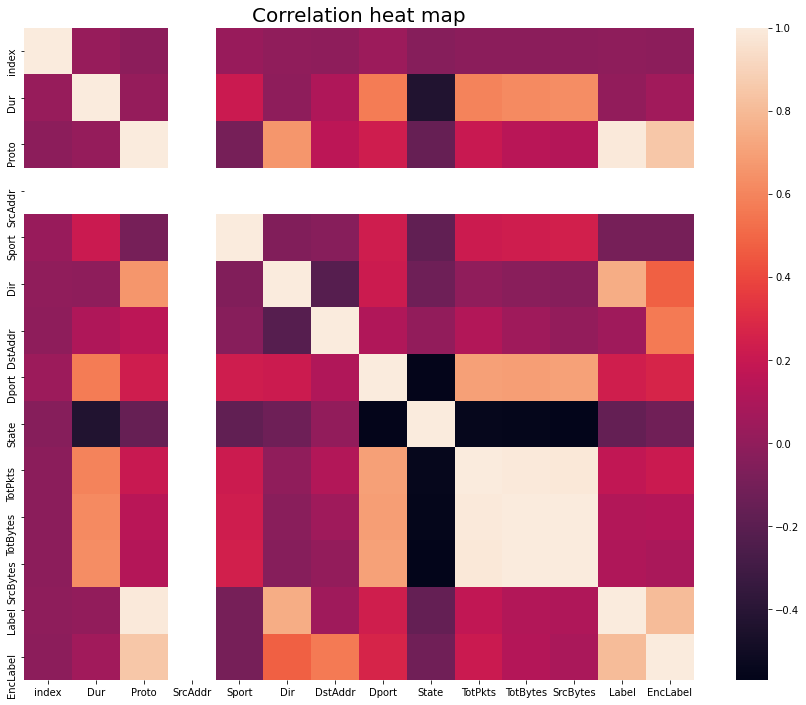

In [20]:
# Let's look at a correlation heatmap to see which are closely associated with target labels
fig = plt.figure(figsize=(15,12))
sns.heatmap(df_10_enc.corr())
plt.title('Correlation heat map', size=20)

Text(0.5, 1.0, 'Direction (blue) vs. Attack Type (yellow)')

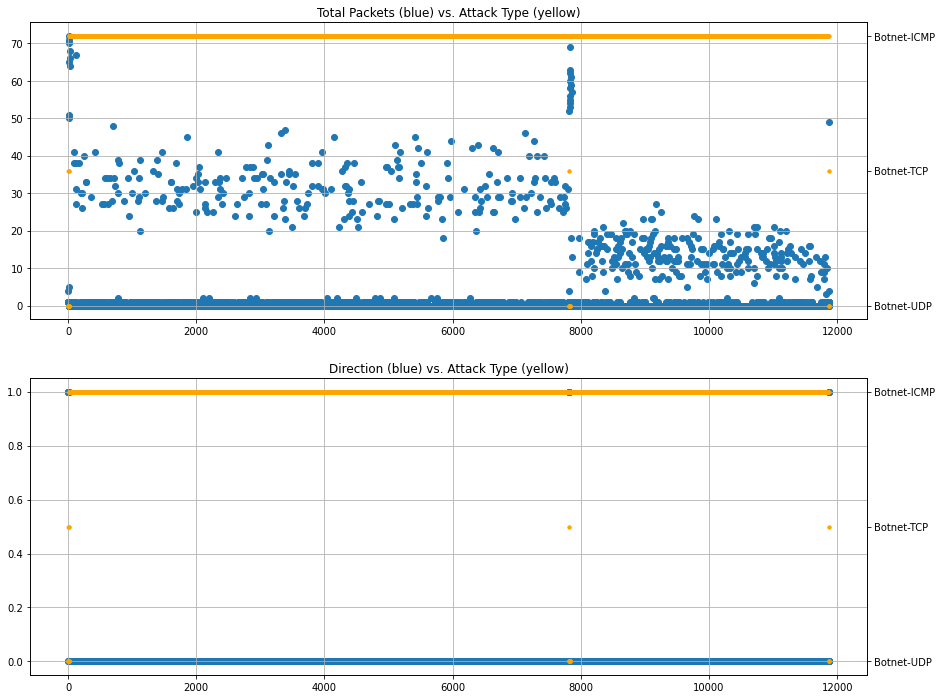

In [21]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))


ax1.scatter(df_10_enc.index, df_10_enc.TotPkts, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10_enc.index, df_10_enc.MetaLabel, marker=".", color='orange', alpha=1)
# ax1.scatter(df_10_enc.index, df_10_enc.TotBytes, marker=".", color='green', alpha=1)
# ax1.legend(['Dport'], loc='upper left')
# ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10_enc.index, df_10_enc.Dir, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10_enc.index, df_10_enc.MetaLabel, marker=".", color='orange', alpha=1)
# ax3.legend(['TotPkts'], loc='center left')
# ax4.legend(['Label'], loc='center right')

ax1.set_title('Total Packets (blue) vs. Attack Type (yellow)')
ax3.set_title('Direction (blue) vs. Attack Type (yellow)')



### 1b. Discretize selected features

As we see above, `Protocol` is most directly correlated with the encoded label. However, this is largely because `EncLabel` is a feature derived from `Protocol`, so we ignore it. Furthermore, the vast majority (>99%) of the values in `Proto` are `ICMP`, so the data is incredibly unbalanced.

The next highest correlation is `DstAddr`. Now, attackers can theoretically choose any target as a victim, so filtering destinations likely won't help us with a general model. 

Following that, the next highest correlation is `Dport`, but the vast majority of the dataset has been backfilled to `0` because most of the Dport values were `NaN`. This means that `Dir` and `TotPkts` are the next 2 most correlated features to the target labels.

Text(0.5, 1.0, 'Direction value counts (log scale)')

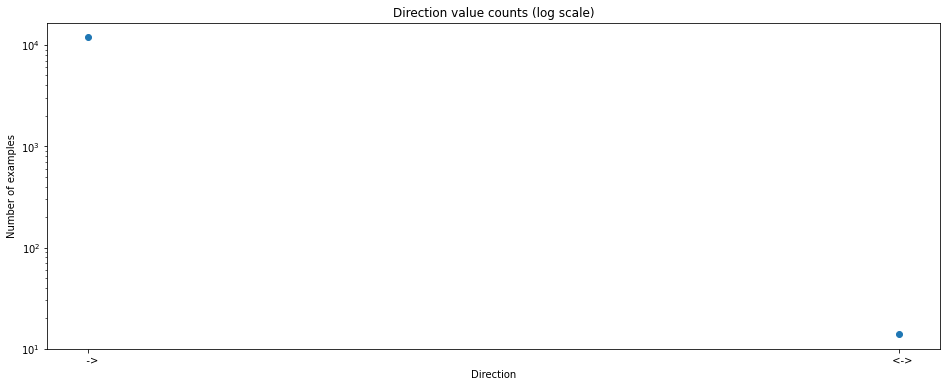

In [22]:
# Let's see the distribution of each encoded port:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
# ax1 = plt.twinx()
plt.scatter(df_10_inf_1.Dir.value_counts().sort_index().index.values, df_10_inf_1.Dir.value_counts().sort_index())
# ax.scatter(df_10_enc.Dir.value_counts().sort_index().index.values, df_10_enc.Dir.value_counts().sort_index())
plt.ylabel('Number of examples')
plt.xlabel('Direction')
plt.title('Direction value counts (log scale)')

We see above that `DstAddr = 1` has far more attacks against it than any other port from this specific host.

Text(0.5, 1.0, 'Total number of packets value counts (log scale)')

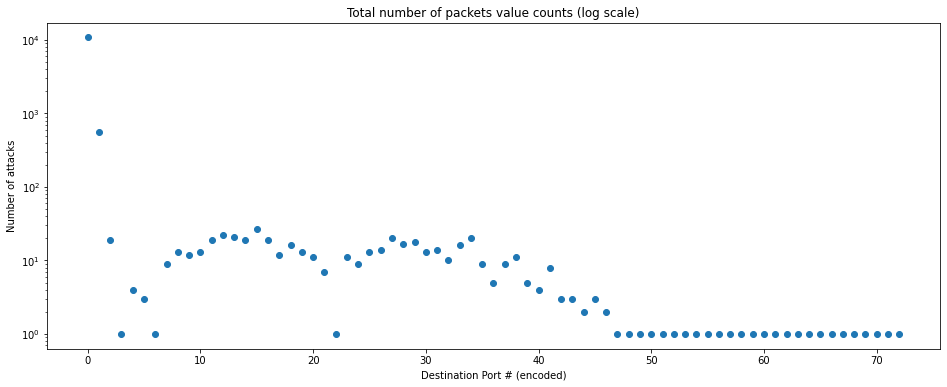

In [23]:
# Let's see the distribution of each encoded port:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
# sorted_counts = np.sort(df_10_enc.Dport.value_counts().index)
plt.scatter(df_10_enc.TotPkts.value_counts().sort_index().index.values, df_10_enc.TotPkts.value_counts().sort_index())
plt.ylabel('Number of attacks')
plt.xlabel('Destination Port # (encoded)')
plt.title('Total number of packets value counts (log scale)')

Apply the discretization to the entire dataset:

In [24]:
# We can see that Dport and Dir are the two most outstanding features with the Metalabel w.r.t. botnet behavior
# Let's combine these with the encoded labels


df_10_inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_10_enc = df_10_inf.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)

df_10_enc['EncLabel'] = pd.Series()
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3
df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')


df_10_enc['DTP'] = df_10_enc.Dir.astype('str') + df_10_enc.TotPkts.astype('str')
df_10_x = pd.concat([df_10_enc.DTP, df_10_enc.MetaLabel, df_10_enc.EncLabel], axis=1)

df_10_x.DTP.value_counts()

<ipython-input-24-720fa04a273d>:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()


00      96238
01       4697
011       218
012       197
09        194
        ...  
0139        1
0108        1
0150        1
082         1
0123        1
Name: DTP, Length: 240, dtype: int64

In [25]:
# Let's bin the values into 3 categories:

# w = the most common value
w = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[0])]).index]
# x = the second most common value
x = df_10_x.iloc[pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP == df_10_x.DTP.value_counts().index[1])]).index]

# y+z = all the other values binned into the 3rd most common value
y = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[0])])
z = pd.Series(df_10_x.DTP.loc[np.where(df_10_x.DTP != df_10_x.DTP.value_counts().index[1])])

y = df_10_x.iloc[pd.Index.intersection(y.index, z.index).astype('int64')]

w.DTP = 1
x.DTP = 2
y.DTP = 3


df_10_x = pd.concat([w,x,y], sort=False).sort_index()
df_10_x

,DTP,MetaLabel,EncLabel
0,3,Botnet-UDP,2
1,3,Botnet-UDP,2
2,3,Botnet-TCP,3
3,3,Botnet-UDP,2
4,3,Botnet-UDP,2
...,...,...,...
106347,1,Botnet-ICMP,1
106348,3,Botnet-UDP,2
106349,3,Botnet-TCP,3
106350,3,Botnet-UDP,2


In [26]:
df_10_x.value_counts()

DTP  MetaLabel    EncLabel
1    Botnet-ICMP  1           96228
3    Botnet-ICMP  1            5080
2    Botnet-ICMP  1            4669
3    Botnet-UDP   2             255
     Botnet-TCP   3              82
2    Botnet-UDP   2              28
1    Botnet-UDP   2              10
dtype: int64

In [27]:
# really dirty way of creating n-grams, but I'll take it

gram = [int(str(df_10_x.DTP.iloc[0]) + str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2])),
         int(str(df_10_x.DTP.iloc[1]) + str(df_10_x.DTP.iloc[2]) + str(df_10_x.DTP.iloc[3]))]

ctr = 2
for item in df_10_x.DTP[2:]:

    gram.append(int(str(df_10_x.DTP.iloc[ctr - 2]) + str(df_10_x.DTP.iloc[ctr - 1]) + str(df_10_x.DTP.iloc[ctr])))
    ctr += 1

df_10_x['gram'] = gram

### 1b. Answers and explanation

Going off of correlation, many of the attributes with high correlation to attack labels are those that are difficult to generalize, e.g. `DstAddr` which are circumstantial, and `Dport` which was largely `NaN` and needed to be ignored. Therefore, we combined the attributes `Dir` and `TotPkts`, and binned them into three categories: `0`, `1`, and `2`.


## 2. Frequent task – 1/2 A4 (Individual) - Srinath (5049903)

### 2a. Use the SPACE SAVING algorithm

The space saving algorithm is given below for your reference:

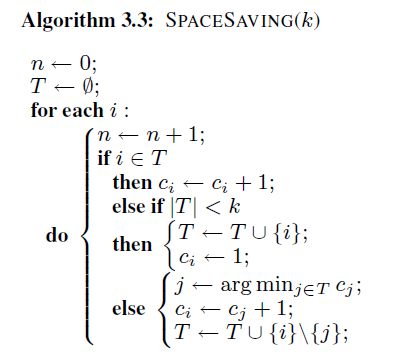

Here is what we will be doing for this task:
- Stream the ngrams using a for loop
- Keep track of the "space saving" count
- Use different values of k as mentioned in the assignment
- Compare the space saving count with the actual count

In [28]:
import pandas as pd
from collections import OrderedDict
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import operator

In [126]:
def spacesaving(data,k): #this function takes 2 inputs - the dataframe of discretized symbols and the value of k
    """
    count - counter variable
    T - elements we are tracking
    """
    count = {}
    T = []
    
    for token in data['gram']: #"gram" is the column in the discretized dataframe from task 1 that contains the ngrams
        if(token in T): 
            count[token] += 1 #if an incoming element is one that we are keeping a track of, increment count by 1

        elif len(T) < k-1: #if the element is less than k-1, add it to the list of elements we are tracking and set its count to 1
            T.append(token) 
            count[token] = 1

        else:
            for newtoken in T:
                count[newtoken] = count[newtoken] - 1

                if(count[newtoken]==0): #if neither of the above conditions are satisfied, replace the element with minimum count
                    T.remove(newtoken)
                    del(count[newtoken])
    return count

df_freq = pd.read_csv("./df_x_disc.csv") #this is the discretized dataframe from task 1 

# run the space saving algorithm - I am choosing an arbitrary set of values for k

for k in [10,20,50,75,125,175,250,300]:

    ss_count = spacesaving(df_freq,k)
    
    # operator.itemgetter (see below) fetches the nth element of an iterable input, in this case the second element (since indices start with 0)

    ss_count_sorted = sorted(ss_count.items(), key=operator.itemgetter(1)) 
    
    ss_count_sorted.reverse() #we are reversing the list here since we need to fetch the top 10 3-grams (sorting by descending, basically)
    
    print("Space Saving count with k="+ str(k) +": "+ str(ss_count_sorted[0:10])) # 0:10 will fetch the top 10 3 grams 
    
    print("\n")

Space Saving count with k=10: [(111, 112158), (131, 2909), (311, 2839), (113, 2826), (121, 2230), (112, 2226), (211, 2213), (333, 123)]


Space Saving count with k=20: [(111, 128321), (113, 15141), (311, 13814), (131, 10127), (211, 5484), (112, 4793), (333, 4129), (133, 4116), (121, 4022), (331, 3261)]


Space Saving count with k=50: [(111, 134204), (113, 21024), (311, 19697), (131, 16010), (211, 11360), (112, 10035), (333, 10012), (133, 9999), (331, 9144), (121, 8579)]


Space Saving count with k=75: [(111, 134204), (113, 21024), (311, 19697), (131, 16010), (211, 11360), (112, 10035), (333, 10012), (133, 9999), (331, 9144), (121, 8579)]


Space Saving count with k=125: [(111, 134204), (113, 21024), (311, 19697), (131, 16010), (211, 11360), (112, 10035), (333, 10012), (133, 9999), (331, 9144), (121, 8579)]


Space Saving count with k=175: [(111, 134204), (113, 21024), (311, 19697), (131, 16010), (211, 11360), (112, 10035), (333, 10012), (133, 9999), (331, 9144), (121, 8579)]


Space Sa

In [127]:
print('The true counts of the 10 most frequent 3-grams:')
print(df_freq.gram.value_counts()[:10])
print('---')

The true counts of the 10 most frequent 3-grams:
111    134204
113     21024
311     19697
131     16010
211     11360
112     10035
333     10012
133      9999
331      9144
121      8579
Name: gram, dtype: int64
---


### 2b. Analysis and answers to the questions

As we can see from the outputs above, beyond a value of 50 for k, the actual count and the space saving count are exactly the same, which means that space saving is a reliable technique to utilise when we require accurate counts.|

## 3. Sketching task – 1/2 A4 (Individual) (Andrew)

### 3a. COUNT-MIN sketch


In [31]:
# count-min sketch - w columns, d rows, k col index

class CountMinSketch:
    
    def __init__(self, w=None, d=None):
        if w is not None and d is not None:
            self.w = w
            self.d = d
            self.sketch = np.zeros(shape=(self.d, self.w), dtype=int) 

        else:
            raise Exception('You must provide parameters w (hash function range/number of columns) and d (number of hash functions/rows)')
            

    def create_sketch(self, data):
        
        # Loop over the "stream" of incoming data
        for i in data:
            # For each row/hash function in the sketch
            for j in range(self.d):
                
                # find the column k to increment for row j
                k = (mmh3.hash(str(i), j) % self.w)
                self.sketch[j][k] += 1
                
        return self.sketch
                
    
    def query_sketch(self, val):
    
        minimum = (2**32)-1
                
        # For each of the hash functions/rows
        for j in range(self.d):
            
            # Get the column k
            k = (mmh3.hash(str(val), j) % self.w)
            
            # Determine the global minimum across all rows
            minimum = np.minimum(minimum, self.sketch[j][k])

        return minimum

In [32]:
# Let's play with some w/d values to get some idea of how well it works:
DEBUG = False

# Define various ranges
w_ranges = [int(np.exp(1)/0.5), int(np.exp(1)/0.1), int(np.exp(1)/0.001),  int(np.exp(1)/0.0001)]
d_ranges = [int(np.log(1/0.01)), int(np.log(1/0.0001)), int(np.log(1/0.00001)), int(np.log(1/0.000001))]

# For the graphs later
dims = []
sizes = []
accuracies = []


for w in w_ranges:
    for d in d_ranges:
        
        sizes.append(w*d)
        dims.append(str((w, d)))
        
        # Define a new sketch for each w,d combo
        CMS = CountMinSketch(w, d)
        sketch = CMS.create_sketch(df_10_x.gram.values)
        
        # store the overcount discrepancy
        overcounts = []
        
        # Determine the true values vs. the estimated values
        for index, loc in zip(df_10_x.gram.value_counts().index.values, range(len(df_10_x.gram.value_counts().index.values))):
            true_val = df_10_x.gram.value_counts().iloc[loc]
            est_val = CMS.query_sketch(index)
            overcounts.append((est_val-true_val))
            
            if(DEBUG):
                print('True count of value:', index, ': ', true_val)
                print('True count of value:', index, ': ', est_val)    
                print('Discrepancy: ', est_val - true_val)
                print('Undercounted?', (est_val - true_val < 0)) # was checking to make sure CountMinSketch was working

        accuracies.append(sum(overcounts))
        
# find the average discrepancy per sketch
avg_disc = []
for i, j in zip(accuracies, sizes):
    avg_disc.append(i/j)

### 3b. Analysis and answers to the questions

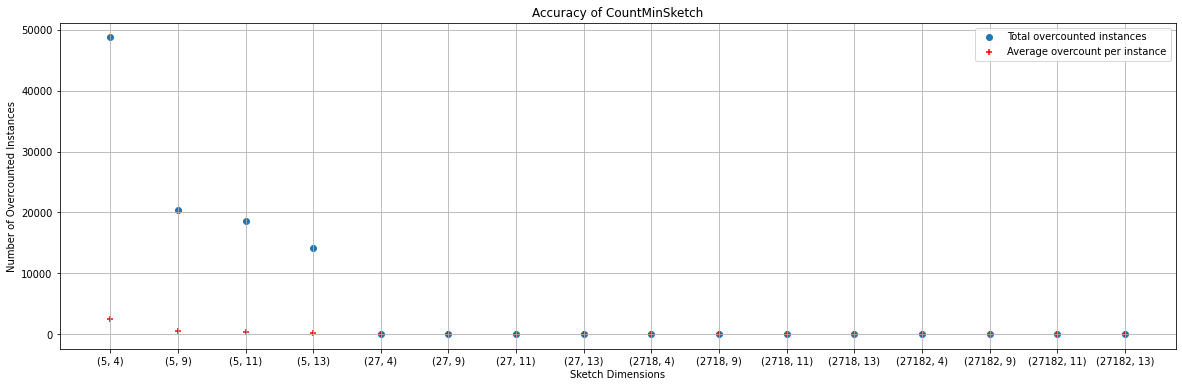

In [33]:
###
# What happens when you play with the w, d values (the dimensions of the sketch)
###


fig = plt.figure(figsize=(20,6))


plt.scatter(dims, accuracies, marker='o', alpha=1)

plt.scatter(dims, avg_disc, marker='+', color='r', alpha=1)
plt.grid()
plt.xlabel('Sketch Dimensions')
plt.ylabel('Number of Overcounted Instances')
plt.title('Accuracy of CountMinSketch')
plt.legend(['Total overcounted instances', 'Average overcount per instance'])

We can see above that there's a steep dropoff after the number of columns `w` starts to grow. Eventually, the sketch makes no mistakes and never overcounts.

In [34]:
###
# What are the 10 most frequent 3-grams and their frequencies when approximated?
###

print('The true counts of the 10 most frequent 3-grams:')
print(df_10_x.gram.value_counts()[:10])


The true counts of the 10 most frequent 3-grams:
111    79369
131     4212
311     4184
113     4172
121     3836
112     3831
211     3819
333      287
313      265
133      256
Name: gram, dtype: int64


In [35]:
CMS_big = CountMinSketch(w=int(np.exp(1)/0.1), d=int(np.log(1/0.001)))
sketch_big = CMS_big.create_sketch(df_10_x.gram)

estimates = []
for item in df_10_x.gram.value_counts().index[:10].values:
    estimates.append((item, CMS_big.query_sketch(item)))

print('Estimate counts of the 10 most frequent 3-grams:')
estimates

Estimate counts of the 10 most frequent 3-grams:


[(111, 79369),
 (131, 4212),
 (311, 4184),
 (113, 4172),
 (121, 3836),
 (112, 3831),
 (211, 3819),
 (333, 287),
 (313, 265),
 (133, 256)]

We can see from the results above that once we reach the dimensions of `w = e/0.1 = 27` and `d = log(1/0.001) = 6` we had 0 overcounts, meaning the true frequencies were identical to the approximated frequencies.

## 4. Min-wise locality sensitive hashing task – 1/2 A4 (Individual) - srinath (5049903)

### 4a. Implementation

In [36]:
from tqdm import tqdm
from collections import defaultdict
from itertools import permutations
import pandas as pd
from nltk import ngrams
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

In [37]:
df_10_x['SrcAddr'] = df_10_enc.SrcAddr
df_10_x['DstAddr'] = df_10_enc.DstAddr

src = sorted(df_10_x.SrcAddr.unique())
dst = sorted(df_10_x.DstAddr.unique())

In [38]:
df_10_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106352 entries, 0 to 106351
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   DTP        106352 non-null  int64 
 1   MetaLabel  106352 non-null  object
 2   EncLabel   106352 non-null  int8  
 3   gram       106352 non-null  int64 
 4   SrcAddr    106352 non-null  int32 
 5   DstAddr    106352 non-null  int32 
dtypes: int32(2), int64(2), int8(1), object(1)
memory usage: 4.2+ MB


In [63]:
df = []

#not sure why, but if you remove the groupby command in the for loop, it fails with 
#"ValueError: too many values to unpack (expected 2)"

#not enough of an expert in pandas to narrow down the exact reason for this error so i am keeping the groupby
#since it doesn't seem to negatively affect the final results

#grouping the dataframe by src and destination and returning src, dst, and DTP

for (src, dst) in df_10_x[["SrcAddr", "DstAddr", "DTP"]].groupby(["SrcAddr", "DstAddr"]):
    ng = df_10_x["gram"].unique()
    dfs = pd.get_dummies(pd.Series(ng)) #get_dummies - Convert categorical variable into dummy/indicator variables.
    df.append(dfs) #Append rows of dfs to the end of df, returning a new object. Columns in dfs that are not in df are added as new columns.

In [64]:
profile = pd.concat(df).fillna(0)
profile

,111,112,113,121,122,123,131,132,133,211,...,233,311,312,313,321,322,323,331,332,333
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
#we are transposing the profile so that the rows contain unique ngrams 
profile_transpose = profile.T

#converting to numpy for use in a for loop
profile_transpose = profile_transpose.to_numpy()
profile_transpose.shape

(27, 2781)

In [43]:
# create permutations of the 2781 columns after transposing
perms = list(permutations([i for i in range(profile_transpose.shape[1])], 2))
len(perms)

7731180

### 4b. Analysis and answers to the questions

## 5. Random hyperplane locality sensitive hashing task – 1/2 A4 (Individual) (Andrew)

- Generate a vector of the occurences of a specific 3-gram. (value_counts())
- Generate a random vector with random values (normal distribution?) and that's a hyperplane because it's perpendicular to some kind of line. Store those hyperplanes, don't do it repeatedly (5, 10, 20, k?)
- Dot product for each random vector and the 3-gram profile (counts) vector:
    - provides a negative (encode as 0?) or positive value (encode as 1?)
    - Do this _ times, and concatenate each 0/1 value into a string of binary values (this is your "hash")
        - too few or too many hyperplanes is bad, choose a "sensible" value. Explain why. 
- Compute pairwise distances for all, and those that are malicious hosts.
    
    
- You have to transform your N-gram counts to 'feature vectors' such as a long list of counts. If you have e.g. 500 possible N-grams then you will have 500 counts. This you can see as a point in a 500-dimensional space
- To then choose random hyperplanes for separating you can generate K vectors of length 500. These could be your normal vectors (then your hyperplanes go through the origin).
- The counts of N-grams are a point in the space and they are on a certain side of the hyperplanes. You can determine this side by taking the sign of the dot product between your counts vector and the normal vector. Sign -1 could map to 0 and 1 to 1.

- **LSH w/ random hyperplanes:** Sicco - "You have some data points, then you have some planes that you draw, then for every plane you get a 0/1 classification whether or not a data point lies on which side of the hyperplane. Compute the labels for all datapoints, and then compute pairwise distances between data points that have that specific label. It can be compared against a full nearest-neighbor search to see performance/speed, but not required."

### 5a. Implementation - locality sensitive hashing

In [ ]:
df_10_x['SrcAddr'] = df_10_enc.SrcAddr
df_10_x['DstAddr'] = df_10_enc.DstAddr

In [ ]:
# flow_names = []
# for i in sorted(df_10_x.SrcAddr.unique()):
#     for j in sorted(df_10_x.DstAddr.unique()):
#         name = 'df_10_flow_' + str(i) + '_' + str(j)
#         flow_names.append(name)
# flow_names

In [ ]:
src = sorted(df_10_x.SrcAddr.unique())
dst = sorted(df_10_x.DstAddr.unique())

non_empty_flows = []
profiles = []
flow_hashes = []

# for each source address
for i in src:
    # for each destination address
    for j in dst:
        # if the flow is more than a single packet
        if (len(df_10_x[(df_10_x.SrcAddr == i) & (df_10_x.DstAddr == j)]) > 1):

            # save the non-empty flow for later
            flow = pd.DataFrame(df_10_x[(df_10_x.SrcAddr == i) & (df_10_x.DstAddr == j)])


            # the profile for this specific src-dst flow
            profile = pd.DataFrame(columns = ['gram', 'counts'])
            profile.gram = sorted(df_10_x.gram.unique())
            profile.counts = pd.Series(np.zeros(shape=(27)))

            # loop over all possible n-grams
            for t in profile.gram:

                # if n-gram `t` is in the flow
                if t in flow.gram.value_counts():

                    # set the count value of that n-gram IN THE PROFILE = the count found in the flow
                    profile.counts.iloc[np.where(profile.gram == t)] = flow.gram.value_counts()[t]

                else: # set the count value to 0 (the gram is not in the profile)
                    profile.counts.iloc[np.where(profile.gram == t)] = 0

                    
                    
            # the number of random hyperplanes (arbitrary for now)
            k = 5

            proj_vals = []
            
            # generate K random vectors
            for m in range(k):

                # create a column of random gaussians
                random_vector = 'rv_' + str(m)
                profile[random_vector] = pd.Series(np.random.normal()*x for x in profile.counts)
                
                # the hash is the encoded dot product between the count vector and the random hyperplane
                # if the dot product is less than 0, encode as 0
                # if the dot product is equal/greater than 0, encode as 1
                if(np.dot(profile.counts, profile[random_vector]) < 0):
                    proj_vals.append(str(0))
                else:
                    proj_vals.append(str(1))
                    
            # concatenate all of these projections into a single string
            temp = ''
            for n in proj_vals:
                temp = temp + n
            flow_hashes.append(temp)
                    

            
                
            # add to the list of profiles   
            profiles.append(profile)

flow_hashes = pd.Series(flow_hashes)

In [ ]:
profiles = pd.Series(profiles)
profiles

0         gram  counts      rv_0       rv_1      rv_...
1         gram  counts         rv_0         rv_1    ...
2         gram  counts      rv_0      rv_1      rv_2...
3         gram  counts      rv_0      rv_1      rv_2...
4         gram  counts      rv_0      rv_1       rv_...
5         gram  counts         rv_0         rv_1    ...
6         gram  counts      rv_0      rv_1      rv_2...
7         gram  counts      rv_0      rv_1      rv_2...
8         gram  counts       rv_0       rv_1      rv...
9         gram  counts         rv_0         rv_1    ...
10        gram  counts      rv_0      rv_1      rv_2...
11        gram  counts      rv_0      rv_1      rv_2...
12        gram  counts       rv_0      rv_1      rv_...
13        gram  counts         rv_0         rv_1    ...
14        gram  counts      rv_0      rv_1      rv_2...
15        gram  counts      rv_0      rv_1      rv_2...
16        gram  counts      rv_0      rv_1      rv_2...
17        gram  counts      rv_0      rv_1      

In [ ]:
profile_counts = []
for profile in profiles:
    temp = ''
    for count in profile.counts:
        temp = temp + str(int(count))
    profile_counts.append(temp)   
profile_counts = pd.DataFrame(profile_counts, columns=['counts'])
profile_counts['flow_hashes'] = flow_hashes
profile_counts

,counts,flow_hashes
0,0010000010000000010000010014,01001
1,7118335404368231333021323682023212218223521325...,10111
2,000000000000000000000000021,00000
3,000000001000000000000000001,10001
4,0000000000000000020000020013,10110
5,7798408408385282238211334042721201011013672121...,00101
6,001000000000000000000000001,01010
7,000000000000000000000000021,10111
8,0000000000000000020000020010,11101
9,7722393415360181039918283902120330121014251329...,00001


In [ ]:
def jaccard_sim(str1, str2):
    intersection = ''
    similarities = []


    for i, j in zip(str1, str2):
        if (i == j):
            intersection = intersection + str(i)


    inters = len(intersection)
    union = len(str1) + len(str2) - len(intersection)
    similarity = inters/union
    
    return similarity

In [ ]:
def collision_test():
    for i in profile_counts.index:
        for j in profile_counts.index:
            if (i != j and profile_counts.flow_hashes.iloc[i] == profile_counts.flow_hashes.iloc[j]):
                jaccard_sim(profile_counts.counts.iloc[i], profile_counts.counts.iloc[j])
    
    
def overall_test():
    for i in profile_counts.index:
        for j in profile_counts.index:
            if (i != j):
                jaccard_sim(profile_counts.counts.iloc[i], profile_counts.counts.iloc[j])

In [ ]:
start = time.time()
for i in range(1000):
    collision_test()
end = time.time()

print('Total runtime (seconds) of 1000 pairwise searches of flows with hash collisions:', end-start)
print('Average runtime (seconds) of a single pairwise search of flows with hash collisions:', (end - start) / 1000)

In [ ]:
start = time.time()
for i in range(1000):
    overall_test()
end = time.time()

print('Total runtime (seconds) of 1000 pairwise searches of all profile vectors:', end-start)
print('Average runtime (seconds) of a single pairwise search of all profile vectors:', (end - start) / 1000)

**Above, we can see that the average run-time for a pairwise similarity comparison of two profile vectors is approximately 15% slower than a comparison of the similarity of two hash-based signatures of a profile.**

In [ ]:
def collision_test_2():
    collision_similarities = []
    for i in profile_counts.index:
        for j in profile_counts.index:
            if (i != j and profile_counts.flow_hashes.iloc[i] == profile_counts.flow_hashes.iloc[j]):
                collision_similarities.append(jaccard_sim(profile_counts.counts.iloc[i], profile_counts.counts.iloc[j]))
    return collision_similarities
    
def overall_test_2():
    overall_similarities = []
    for i in profile_counts.index:
        for j in profile_counts.index:
            if (i != j):
                overall_similarities.append(jaccard_sim(profile_counts.counts.iloc[i], profile_counts.counts.iloc[j]))
    return overall_similarities

In [ ]:
collision_locs = []

# find the locations of the hash collisions
for i in profile_counts.index:
    for j in profile_counts.index:
        if (i != j and profile_counts.flow_hashes.iloc[i] == profile_counts.flow_hashes.iloc[j]):
            collision_locs.append((i,j))


# compare the jaccard similarities between the hash collisions (going to be 1.0) and the count vectors themselves (varies widely)
over_sims = []
hash_sims = []
for i in collision_locs:
    hash_sims.append(jaccard_sim(profile_counts.flow_hashes.iloc[i[0]], profile_counts.flow_hashes.iloc[i[1]]))
    over_sims.append(jaccard_sim(profile_counts.counts.iloc[i[0]], profile_counts.counts.iloc[i[1]]))


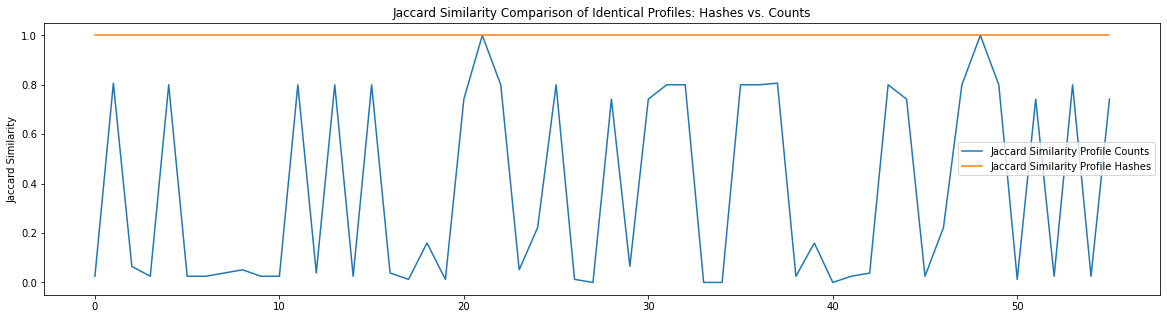

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,5))

plt.plot(over_sims)
plt.plot(hash_sims)

plt.title('Jaccard Similarity Comparison of Identical Profiles: Hashes vs. Counts')
plt.ylabel('Jaccard Similarity')
plt.legend(['Jaccard Similarity Profile Counts', 'Jaccard Similarity Profile Hashes'])

In [ ]:
print(np.min(over_sims),'-', np.max(over_sims))

0.0 - 1.0


**Of course, the jaccard similarity between two hash collisions is going to be 1 (or distance 0). However, it's interesting to see how the count similarity fluctuates for the profiles with the same hashes when comparing the count vectors. The similarity of profiles that have identical hashes varies widely when looking at the count (from ~0.0 to 1.0).**

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

Notes from meeting with Daniel:

- Include all hosts, even non-bots
- Take one botnet host (random?), convert n-grams to a vector for that host, and binarize: 0 if n-gram doesn't appear, 1 if so.
    - Do for all
    - Compare each vector to the botnet vector
    - Create some threshold for classification based on the distance
- Group by host
    - Drop any hosts with small number of examples
    - Create the n-grams
    - Look for n-grams that appear in botnet, but not in benign (something like this?)
    

In [ ]:
# the entire concatenated and discretized dataset (from the first section of the assignment, applied to all scenarios)
# DTP: Destination port + Total Packets, discretized
# gram: 3-gram of DTP

# Dataset with background traffic
# df_x = pd.read_pickle('~/Documents/Delft/CDA 2021/Lab 3/df_x_disc_2.pkl')

# Dataset without background traffic (but still contains normal, non-botnet traffic)
df_x = pd.read_pickle('~/Documents/Delft/CDA 2021/Lab 3/df_x_disc_2_no_background.pkl')
# df_x.drop('Unnamed: 0', axis=1, inplace=True)
df_x

,SrcAddr,DstAddr,DTP,MetaLabel,EncLabel,gram,flow_id
122,61637,56866,3,Normal,1,333,664517
209,61615,14699,3,Normal,1,333,657582
264,61666,50229,3,Normal,1,333,667743
265,61666,50224,3,Normal,1,333,667742
266,61666,33076,3,Normal,1,333,667710
...,...,...,...,...,...,...,...
3829759,11981,7859,1,Normal,1,131,53543
3829760,11981,7859,1,Normal,1,311,53543
3829812,11981,7859,1,Normal,1,111,53543
3829813,11981,7859,1,Normal,1,111,53543


In [ ]:
all_profiles = []
bot_profiles = []
normal_profiles = []

# for each unique source-destination pair
for i in sorted(df_x.flow_id.unique()):

    flow = pd.DataFrame(df_x[(df_x.flow_id == i)])

    
    # create a new profile
    profile = pd.DataFrame(columns=['gram', 'present'])
    profile.gram = sorted(df_x.gram.unique())
    profile.present = pd.Series(np.zeros(shape=(27))) 
    
    # for each unique n-gram (27 possible)
    for gram in profile.gram:
        
        # Binary encoding if this n-gram is present in any of the traffic for this flow_id
        if gram in flow.gram.value_counts():
            profile.present.iloc[np.where(profile.gram == gram)] = int(1)
        else:
            profile.present.iloc[np.where(profile.gram == gram)] = int(0)
    
    # Keep track of the flow_id and profile together
    if (all(df_x.MetaLabel.iloc[np.where(df_x.flow_id == i)].str.contains('Botnet').values)):
        all_profiles.append(('bot', i, profile))
#         bot_profiles.append((i, profile))
        
    if (all(df_x.MetaLabel.iloc[np.where(df_x.flow_id == i)].str.contains('Normal').values)):
        all_profiles.append(('normal', i, profile))
#         normal_profiles.append((i, profile))
        
#     all_profiles.append((i, profile))
    
    
all_profiles = pd.DataFrame(all_profiles, columns = ['class', 'flow_id', 'profile'])
all_profiles

51155
51156
51550
51730
51731
51732
51733
51734
51735
51736
51737
51738
51739
51740
51741
51742
51743
51744
51745
51746
51747
51748
51749
51750
51751
51752
51753
51754
51755
51756
51757
51758
51759
51760
51761
51763
51764
51765
51766
51767
51768
51769
51770
51771
51772
51773
51774
51775
51776
51777
51778
51779
51780
51781
51782
51783
51784
51785
51786
51787
51790
51791
51792
51793
51794
51795
51796
51797
51798
51799
51800
51801
51802
51803
51804
51805
51806
51807
51808
51809
51810
51811
51812
51813
51814
51815
51816
51817
51818
51819
51820
51821
51822
51823
51824
51825
51826
51827
51828
51829
51830
51831
51832
51833
51834
51836
51837
51838
51839
51840
51841
51842
51843
51844
51845
51846
51847
51848
51849
51850
51851
51852
51853
51854
51855
51856
51857
51858
51861
51862
51863
51864
51865
51866
51867
51868
51869
51870
51871
51872
51873
51874
51875
51876
51877
51886
51887
51888
51891
51892
51893
51894
51895
51896
51897
51900
51940
52542
52543
52544
52545
52546
52547
52548
52550
52551
5255

In [ ]:
all_profiles

,class,flow_id,profile
0,normal,51155,gram present 0 111 0.0 1 112 ...
1,normal,51156,gram present 0 111 0.0 1 112 ...
2,normal,51550,gram present 0 111 0.0 1 112 ...
3,normal,51730,gram present 0 111 0.0 1 112 ...
4,normal,51731,gram present 0 111 0.0 1 112 ...
...,...,...,...
29911,normal,806901,gram present 0 111 0.0 1 112 ...
29912,normal,806902,gram present 0 111 0.0 1 112 ...
29913,normal,806903,gram present 0 111 0.0 1 112 ...
29914,normal,806904,gram present 0 111 0.0 1 112 ...


In [ ]:
norm_profiles = all_profiles.loc[all_profiles['class'] == 'normal']
bot_profiles = all_profiles.loc[all_profiles['class'] == 'bot']

In [ ]:
# choose an arbitrary benign baseline to compare to
norm_baseline = all_profiles.profile[0]

# choose an arbitrary bot baseline to compare to
bot_baseline = all_profiles.profile[230]

### 6a. Learn a sequential model

In [ ]:
### THIS ONLY WORKS FOR BINARY VECTORS
# cosine magnitude of binary data is the square root of the sum of the values in the vector
# cosine similarity between two binary vectors is just (V1 * V2)/(mag(V1)*mag(V2))
# cosine distance is just 1-similarity

def cosine_magnitude(vector_1):
    return (np.sqrt(np.sum(vector_1)))

def cosine_similarity(vector_1, vector_2):
    return (np.dot(vector_1, vector_2) / (cosine_magnitude(vector_1) * cosine_magnitude(vector_2)))

def cosine_distance(vector_1, vector_2):
    return (1 - cosine_similarity(vector_1, vector_2))

In [ ]:
similarities = []
distances = []

sim2 = []
dist2 = []

bot_sim = []
bot_dist = []

norm_sim = []
norm_dist = []

for i in all_profiles.index:
    sim2.append(cosine_similarity(bot_baseline.present, all_profiles.iloc[i].profile.present))
    dist2.append(cosine_distance(bot_baseline.present, all_profiles.iloc[i].profile.present))

for i in all_profiles.index:
    similarities.append(cosine_similarity(norm_baseline.present, all_profiles.iloc[i].profile.present))
    distances.append(cosine_distance(norm_baseline.present, all_profiles.iloc[i].profile.present))
    
for i in all_profiles.iloc[np.where(all_profiles['class'].str.contains('bot'))].index:
    bot_sim.append(cosine_similarity(bot_baseline.present, all_profiles.iloc[i].profile.present))
    bot_dist.append(cosine_distance(bot_baseline.present, all_profiles.iloc[i].profile.present))
    
for i in all_profiles.iloc[np.where(all_profiles['class'].str.contains('normal'))].index:
    norm_sim.append(cosine_similarity(norm_baseline.present, all_profiles.iloc[i].profile.present))
    norm_dist.append(cosine_distance(norm_baseline.present, all_profiles.iloc[i].profile.present))   

Text(0.5, 1.0, 'All profiles compared to botnet (red) and normal (blue) baselines')

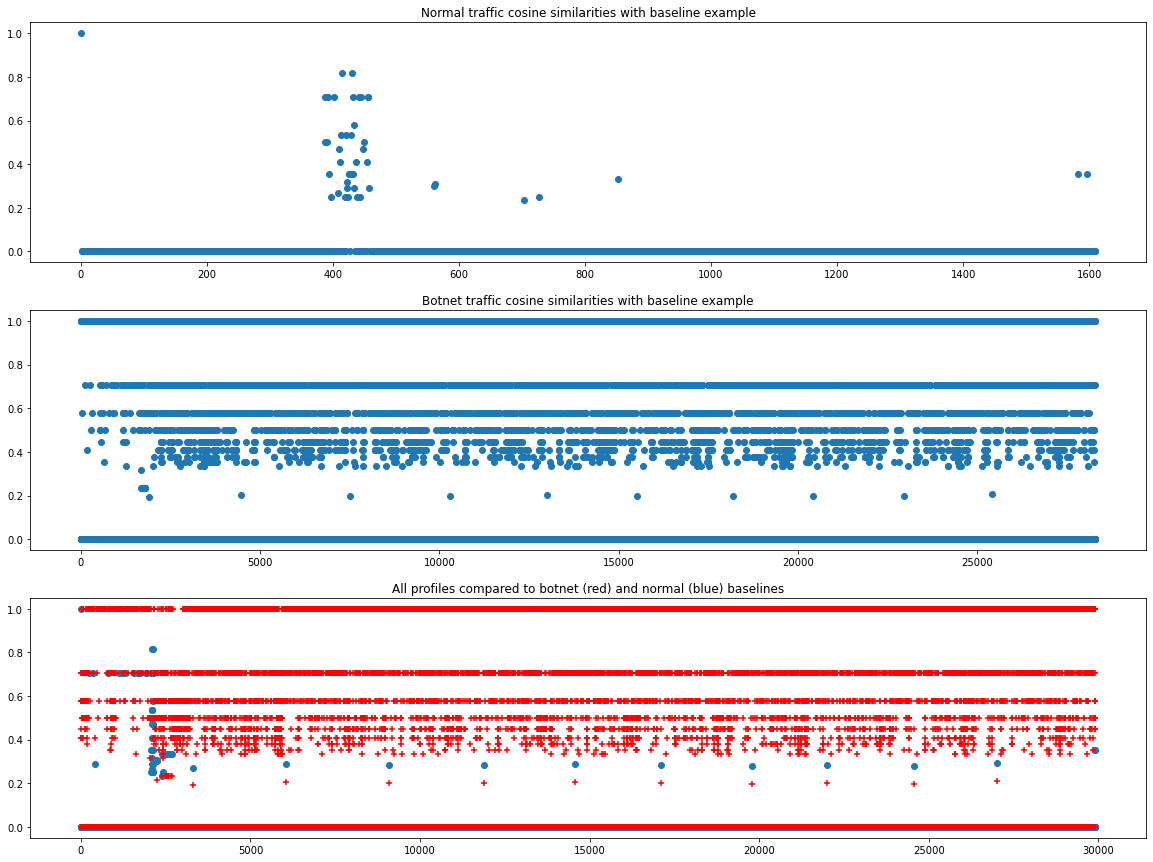

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20,15))
ax1.scatter(range(len(norm_sim)), norm_sim)
ax1.set_title('Normal traffic cosine similarities with baseline example')

# ax1 = ax.twinx()
ax2.scatter(range(len(bot_sim)), bot_sim)
ax2.set_title('Botnet traffic cosine similarities with baseline example')

ax3.scatter(range(len(similarities)), similarities, marker='o')
ax3.scatter(range(len(sim2)), sim2, marker='+', color='r')
ax3.set_title('All profiles compared to botnet (red) and normal (blue) baselines')

In [ ]:
# If we set an arbitrary threshold just above 0, how many bots can we detect?
threshold = 0.01

similarities = pd.Series(similarities)
sim2 = pd.Series(sim2)
bot_sim = pd.Series(bot_sim)
norm_sim = pd.Series(norm_sim)

In [ ]:
np.where(sim2 > threshold)[0]

array([    2,     3,     4, ..., 29910, 29911, 29912], dtype=int64)

In [ ]:
sim2

0        0.000000
1        0.000000
2        0.707107
3        0.577350
4        0.577350
           ...   
29911    1.000000
29912    0.707107
29913    0.000000
29914    0.000000
29915    0.000000
Length: 29916, dtype: float64

In [ ]:
thresholds = [0.01, 0.1, 0.2, 0.5]

num_bots = len(bot_profiles)
num_normal = len(norm_profiles)

for threshold in thresholds:
    print('---')
    
    pred_pos = np.where(sim2 >= threshold)[0]
    pred_neg = np.where(sim2 < threshold)[0]
    
    TPR = len(np.intersect1d(pred_pos, bot_profiles.index)) / num_bots
    TNR = len(np.intersect1d(pred_neg, norm_profiles.index)) / num_normal
    FPR = len(np.intersect1d(pred_pos, norm_profiles.index)) / num_normal
    FNR = len(np.intersect1d(pred_neg, bot_profiles.index)) / num_bots
    
    print('True positive rate for defining arbitrary threshold at Cosine Similarity @', threshold, ':', TPR)

    print('True negative rate for defining arbitrary threshold at Cosine Similarity @', threshold, ':', TNR)
    
    print('False positive rate for defining arbitrary threshold at Cosine Similarity @', threshold, ':', FPR)
    
    print('False negative rate for defining arbitrary threshold at Cosine Similarity @', threshold, ':', FNR)

    
    print('---')

---
True positive rate for defining arbitrary threshold at Cosine Similarity @ 0.01 : 0.3207207207207207
True negative rate for defining arbitrary threshold at Cosine Similarity @ 0.01 : 0.47113594040968343
False positive rate for defining arbitrary threshold at Cosine Similarity @ 0.01 : 0.5288640595903166
False negative rate for defining arbitrary threshold at Cosine Similarity @ 0.01 : 0.6792792792792792
---
---
True positive rate for defining arbitrary threshold at Cosine Similarity @ 0.1 : 0.3207207207207207
True negative rate for defining arbitrary threshold at Cosine Similarity @ 0.1 : 0.47113594040968343
False positive rate for defining arbitrary threshold at Cosine Similarity @ 0.1 : 0.5288640595903166
False negative rate for defining arbitrary threshold at Cosine Similarity @ 0.1 : 0.6792792792792792
---
---
True positive rate for defining arbitrary threshold at Cosine Similarity @ 0.2 : 0.32061473237943827
True negative rate for defining arbitrary threshold at Cosine Similar

As we can see above, setting an arbitrary linear threshold for this task does not yield very good results. Given more time to improve the results, I would start by spending more time engineering the n-grams (potentially larger than a 3-gram, for example) as well as finding a more "generic" baseline profile to compare cosine similarity towards. 

Maybe a simple machine learning model will be better:

In [ ]:
test = pd.DataFrame(df_x.gram.unique())

for i in range(len(all_profiles)):
    col = 'profile_' + str(i)
    test[col] = all_profiles.profile[i].present.values

test

,0,profile_0,profile_1,profile_2,profile_3,profile_4,profile_5,profile_6,profile_7,profile_8,...,profile_29906,profile_29907,profile_29908,profile_29909,profile_29910,profile_29911,profile_29912,profile_29913,profile_29914,profile_29915
0,333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,313,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,131,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
9,111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test2 = test.transpose().drop(0, axis=0, inplace=False)
test2['label'] = LabelEncoder().fit_transform(all_profiles['class'].values)
test2

,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,label
profile_0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
profile_1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
profile_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
profile_3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
profile_4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
profile_29911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
profile_29912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
profile_29913,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
profile_29914,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

strat_kfold = StratifiedKFold(n_splits=10, shuffle=True)

x = test2.drop('label', axis=1, inplace=False)
y = test2.label

for train_index, test_index in strat_kfold.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

SGD = LogisticRegression()

SGD.fit(x_train, y_train)


LogisticRegression()

Text(0.5, 1.0, 'Confusion matrix')

<Figure size 1440x720 with 0 Axes>

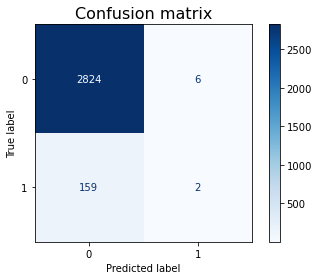

In [ ]:
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support

fig = plt.figure(figsize=(20, 10))

disp = plot_confusion_matrix(SGD, x_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix", fontsize=16)


As we can see above, a Logistic Regression model trained on profile presence vectors, and not cosine similarity, does not improve upon the previous method, though of course it has much fewer false positives because it classifies almost everything as negative.

In [ ]:
print('True positive rate for Logistic Regression on profile presence vectors:', (2)/(2+159))

print('True negative rate for Logistic Regression on profile presence vectors:', (2824)/(2824+6))

print('False positive rate for Logistic Regression on profile presence vectors:', (159)/(159+2))

print('False negative rate for Logistic Regression on profile presence vectors:', (6)/(6+2824))




True positive rate for Logistic Regression on profile presence vectors: 0.012422360248447204
True negative rate for Logistic Regression on profile presence vectors: 0.9978798586572438
False positive rate for Logistic Regression on profile presence vectors: 0.9875776397515528
False negative rate for Logistic Regression on profile presence vectors: 0.0021201413427561835


### 6b. Analysis and answers to the questions.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


### 7b. Analysis and answers to the questions.

## 8. Bonus Task 1/2 A4

In [ ]:
# # We can see below that there's a dramatic shift when the botnet starts receiving ICMP packets. 
# fig, ax = plt.subplots(figsize=(20,15))

# df_x['DTP_1000'] = pd.Series(df_x.DTP.rolling(window=1000).mean()).fillna(method='bfill')
# ax1 = ax.twinx()
# ax1.grid()
# ax.plot(df_x.DTP)
# ax.plot(df_x.DTP_1000)

# ax1.scatter(df_x.index, df_x.MetaLabel, color='red')
# ax1.legend(['Attack Type'])

Be creative?

### 8a. Provide implementation and analysis.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7685e1b1-dbe2-48a5-b4d6-1e83bf269a41' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>